# Boosting kernel density estimates
This notebook will show how boosting kernel density estimates (KDE) can benefit outlier detection.

In [1]:
%matplotlib inline

# Imports from local repository
from examples.data.IO import load_data, rearrange_results_dict
from examples.train_test_classifier import compute_performance
from examples.visualization import adjust_spines, compare_results

# Third-party
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Parameters
verbose = True  # Whether to print messages of cross-validation
n_jobs = -1  # Number of processes for joblib
random_seed = 17

## Cardiotocogrpahy dataset
The original [Cardiotocography (Cardio)](https://archive.ics.uci.edu/ml/datasets/Cardiotocography) dataset from [UCI machine learning repository](https://archive.ics.uci.edu/ml/) consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians. This is a classification dataset, where the classes are normal, suspect, and pathologic. For outlier detection, The normal class formed the inliers, while the pathologic (outlier) class is downsampled to 176 points. The suspect class is discarded.

Source: [ODDS - Outlier Detection DataSets repository](http://odds.cs.stonybrook.edu/cardiotocogrpahy-dataset/)

In [2]:
# Load the cardio dataset
DATA = load_data('cardio')

# Get name and number of variables and classes
variables = [i for i in list(DATA.columns) if not i.startswith('label')]
n_variables = len(variables)
classes = np.unique(DATA['label'])
n_classes = classes.shape[0]

# Set name and color of labels
label_names = ['normal', 'pathological']
colors = ['b', 'r']

print('\nThe dataset contains %i classes: %s' % (n_classes, ', '.join(label_names)))

Loaded dataset 'cardio', containing 1831 observations and 22 variables:
	LB, AC, FM, UC, DL, DS, DP, ASTV, MSTV, ALTV, MLTV, Width, Min, Max, Nmax, Nzeros, Mode, Mean, Median, Variance, Tendency, label

The dataset contains 2 classes: normal, pathological


### Inspecting marginal distributions

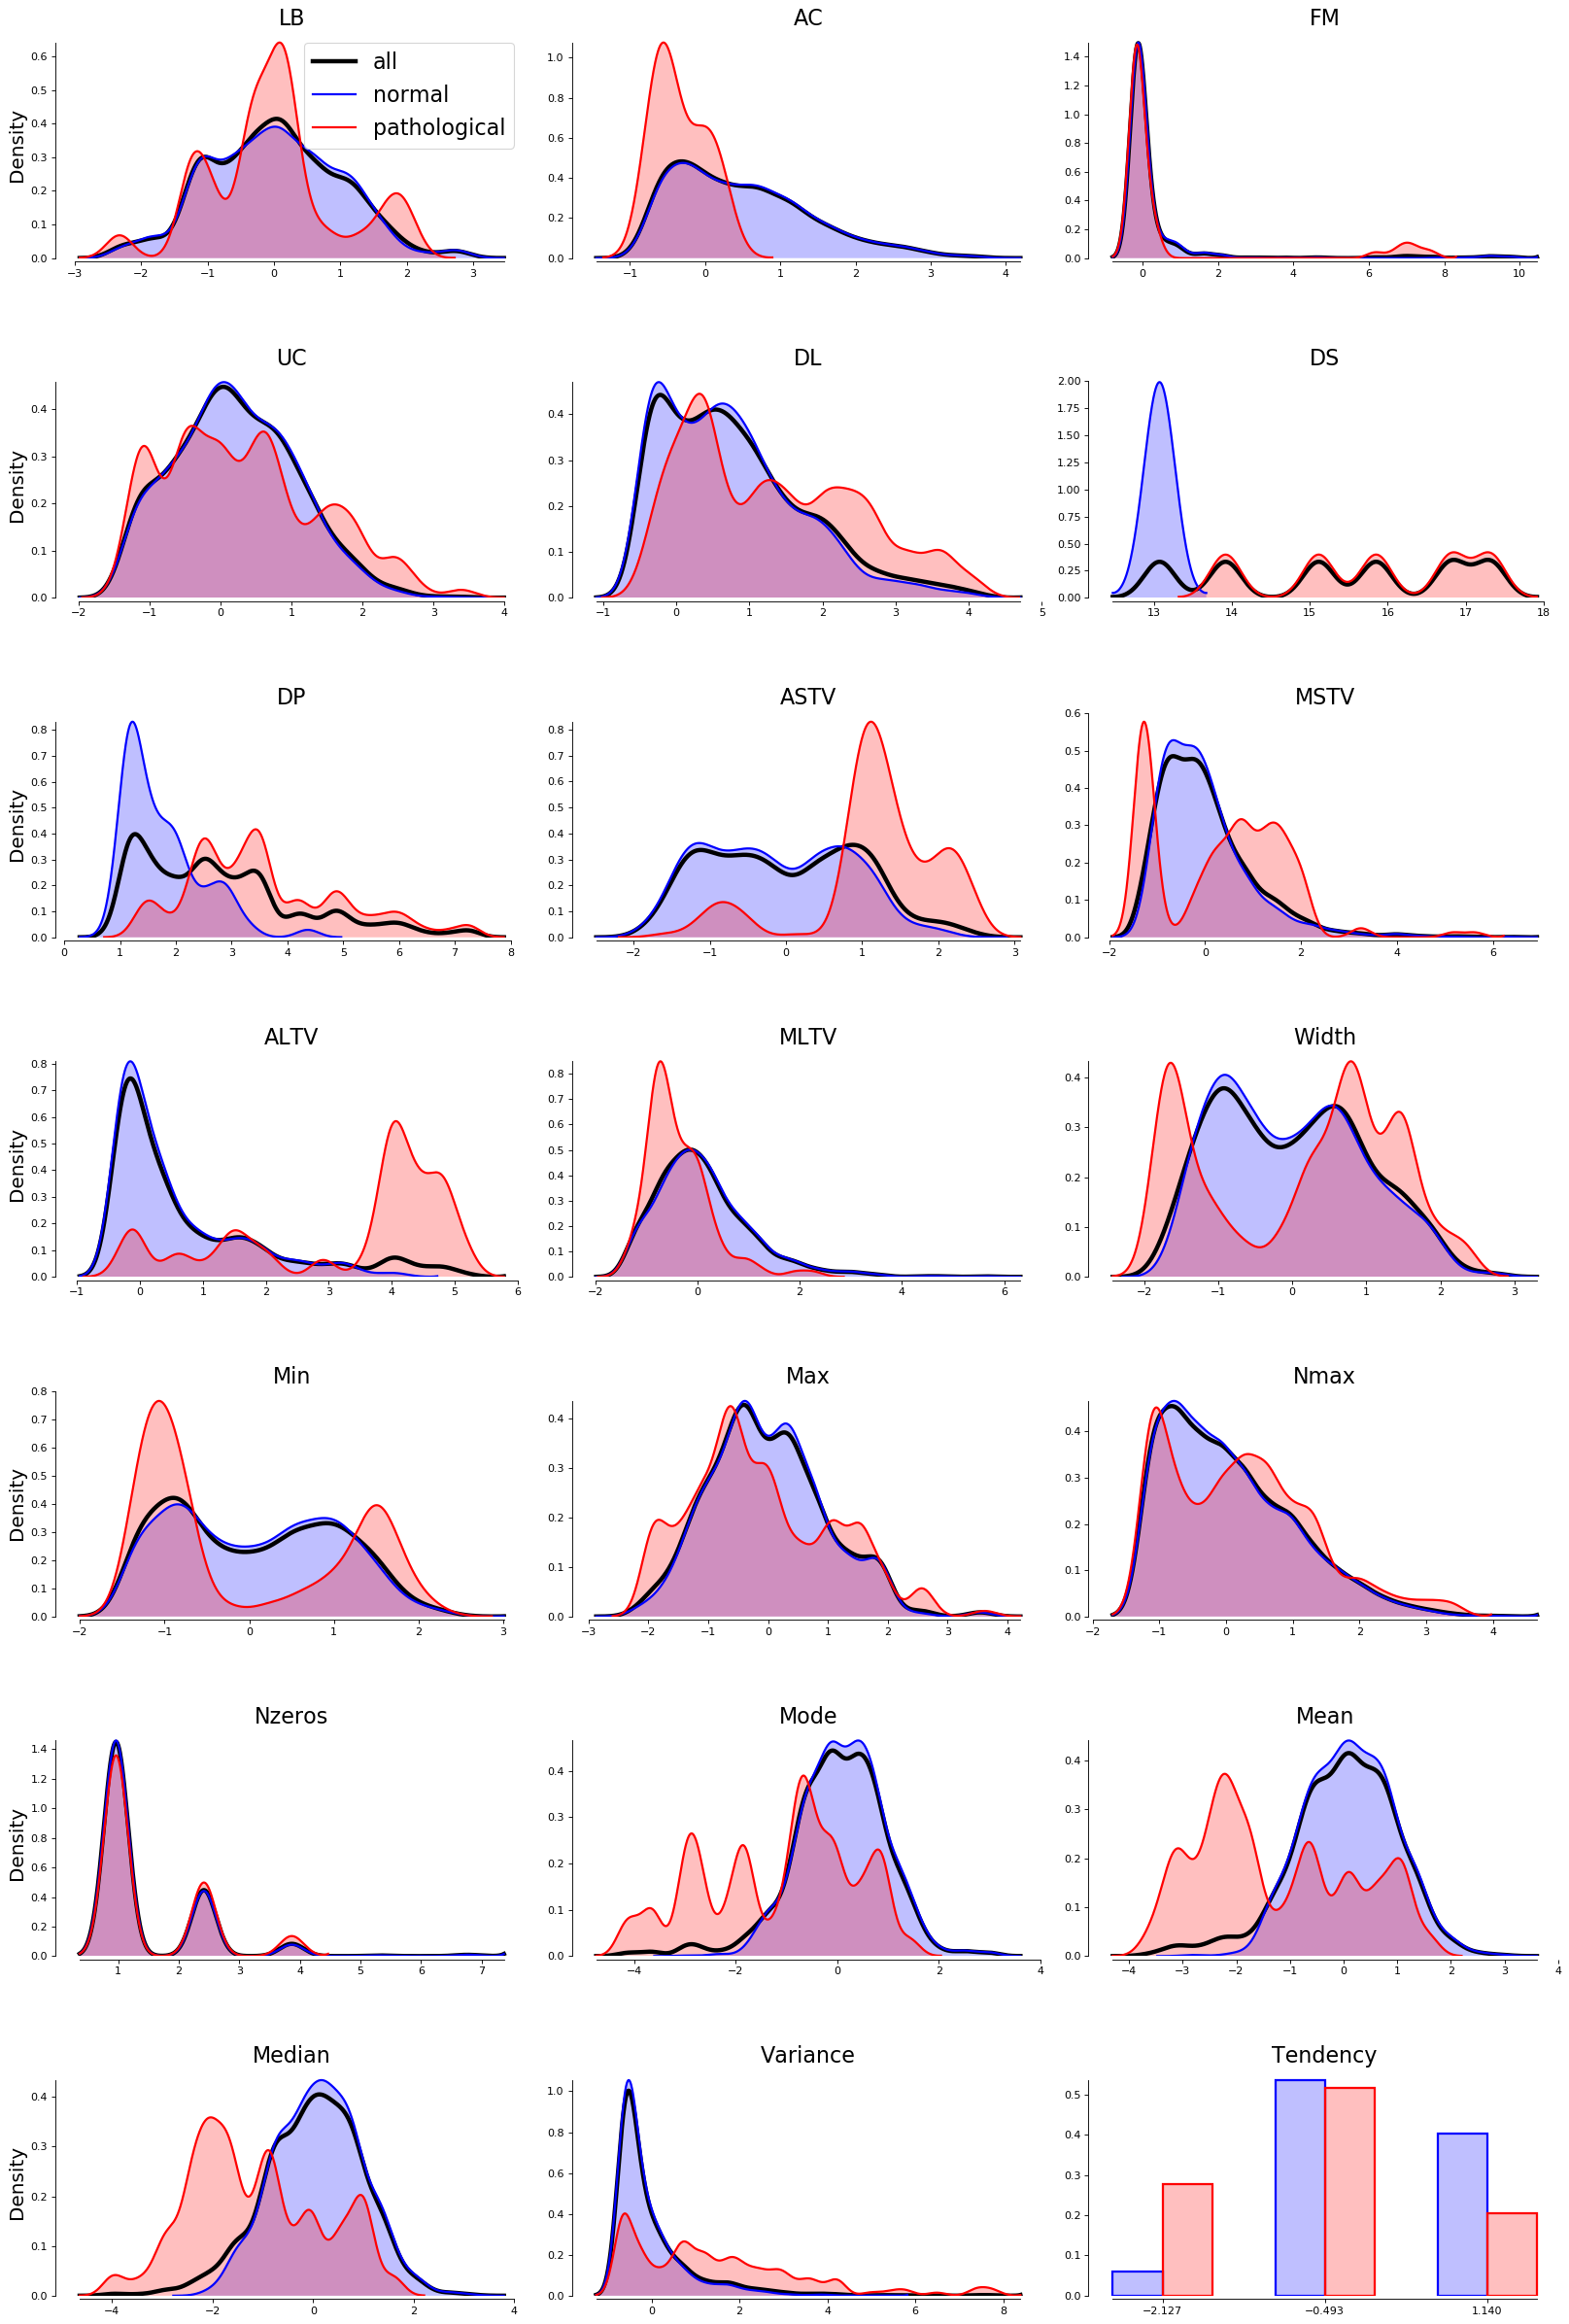

In [3]:
# Open figure
fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(20, 30), dpi= 80)
ax = ax.ravel()

for i_var in range(n_variables):
    # This variable only contains 3 possible values, so we'll plot it below as a simple bar plot
    if variables[i_var] == 'Tendency':
        tendency_i_var = i_var
        continue

    data = DATA[variables[i_var]]
    
    # Plot KDE of all data
    ax[i_var] = sns.kdeplot(data, shade=False, kernel='gau', bw=.2,
                            legend=False, color='k', lw=4,
                            clip=[data.min(), data.max()], 
                            gridsize=1000, ax=ax[i_var], label='all')
        
        
    # Plot KDE of each subgroup
    for i_class, class_label in enumerate(classes):
        ax[i_var] = sns.kdeplot(data[DATA['label'] == class_label], shade=True, kernel='gau', bw=.2,
                                legend=False, color=colors[i_class], lw=2,
                                clip=[data.min(), data.max()], gridsize=1000,
                                ax=ax[i_var], label=label_names[i_class])
    
# Add graph for variable 'Tendency'
# Plan where to place the bars
width = 1 / n_classes
max_offset = n_classes / 2 * width - width / 2
offset = np.linspace(-max_offset, max_offset, n_classes)
xticks = np.unique(DATA['Tendency'])
diff = (xticks[1] - xticks[0]) / 2
bins = np.hstack((xticks - diff, xticks[-1] + diff))
# Loop through classes
for i_class, class_label in enumerate(classes):
    x = xticks + offset[i_class]
    # Compute density for this class
    y = np.histogram(DATA.loc[np.where(DATA['label'] == class_label)[0], 'Tendency'], bins=bins)[0]
    y = y / np.sum(y)
    # Draw contour
    ax[tendency_i_var].bar(x, y, width, facecolor=colors[i_class], alpha=0.25, edgecolor='None')
    # Draw bar
    ax[tendency_i_var].bar(x, y, width, edgecolor=colors[i_class], linewidth=2, facecolor='None')
# Set ticks to only bins avaiable
ax[tendency_i_var].set_xticks(xticks)

# Add titles and legend
for i_var in range(n_variables):
    # Add title
    ax[i_var].set_title(variables[i_var], fontsize=20)
ax[0].legend(fontsize=20)

# Adjust spines and layout of subplots
[adjust_spines(i, ['bottom','left'], smart_bounds=True) for i in ax]
fig.tight_layout()
fig.subplots_adjust(hspace=.5)
# Add y-axes label
[ax[i].set_ylabel('Density', fontsize=18) for i in range(0, n_variables, 3)];


Inspecting the marginal distributions, it appears clear that some variables are better suited than others in separating the two classes.

For example, the class **DS** has a clear-cut separation between the two classes. Thus, using only this variable will represent our "easy case" scenario. **ALTV** is also very convenient, although there is a certain overlap between the two distributions.

We will compare these univariate classification tasks with two multi-variate tasks:
1. Variables **DP**, **DS**, **ASTV**, **ALTV**
2. All variables

Other variables which also seems to achieve good separation (e.g., **Mean**), are a visual artifact of the density histogram plot. In fact, when we compare the black line (representing the data across all classes), it always mostly overlap with the blue curve (the inlier group of healthy subjects). The only exceptions are **DS** and **DP**, where the density of the whole follows mostly the distribution of the outlier group (in red).

In [4]:
# Group of variables to analyze
variable_groups = [['DS'],  # Uni-variate, good separation
                   ['ALTV'],  # Uni-variate, poor separation
                   ['AC', 'DP', 'DS', 'ASTV', 'ALTV'],  # Multi-variate, good separation
                   variables]  # All variables

group_labels = ['univariate, good separation', 'univariate, poor separation',
                'multivariate, good separation', 'all variables']

# List of classifiers and boosting iterations
classification_tasks = [('SVM', 0, None),
                        ('SVM', 1, None),
                        ('ocSVM', 0, None),
                        ('ocSVM', 1, None)]

In [5]:
# Nested k-fold scheme
n_splits = 10
fraction_tuning = .25
n_inner_splits_tuning = 5

# Initialize output variable
results = dict()
for i_group, selected_variables in enumerate(variable_groups):
    results['group_%i' % (i_group + 1)] = dict()
    # Select data, and make sure that they are arranged correctly
    X = DATA[selected_variables].values
    if len(selected_variables) == 1:
        X = X.reshape(-1, 1)
    # Select labels
    y = DATA['label'].values

    print('*' * 80)
    print('Selected variables: %s' % ', '.join(selected_variables))
    print('*' * 80)

    this_results = compute_performance(classification_tasks, X, y,
                                       n_splits=n_splits,
                                       n_inner_splits_tuning=n_inner_splits_tuning,
                                       fraction_tuning=fraction_tuning,
                                       n_jobs=n_jobs,
                                       random_seed=random_seed, verbose=verbose)

    # Store info
    results['group_%i' % (i_group + 1)] = this_results

********************************************************************************
Selected variables: DS
********************************************************************************
CV iteration 1/10
	SVM: C=0.6563, gamma=0.6375, kernel=rbf, performance: 0.90217
	Weighted (k=1) SVM: C=0.2947, gamma=0.5306, kernel=linear, performance: 0.90217
	ocSVM: gamma=0.6563, kernel=linear, nu=0.2195, performance: 0.90217
	Weighted (k=1) ocSVM: gamma=0.6563, kernel=linear, nu=0.2195, performance: 0.90217
CV iteration 2/10
	SVM: C=0.6563, gamma=0.6375, kernel=rbf, performance: 0.90217
	Weighted (k=1) SVM: C=0.2947, gamma=0.5306, kernel=linear, performance: 0.90217
	ocSVM: gamma=0.6563, kernel=linear, nu=0.2195, performance: 0.90217
	Weighted (k=1) ocSVM: gamma=0.6563, kernel=linear, nu=0.2195, performance: 0.90217
CV iteration 3/10
	SVM: C=0.6563, gamma=0.6375, kernel=rbf, performance: 0.90217
	Weighted (k=1) SVM: C=0.2947, gamma=0.5306, kernel=linear, performance: 0.90217
	ocSVM: gamma=0.6563, k

	SVM: C=0.1775, gamma=0.9226, kernel=linear, performance: 0.90217
	Weighted (k=1) SVM: C=0.7973, gamma=0.0680, kernel=rbf, performance: 0.98992
	ocSVM: gamma=0.5023, kernel=linear, nu=0.8589, performance: 0.92906
	Weighted (k=1) ocSVM: gamma=0.5157, kernel=linear, nu=0.0175, performance: 0.99388
CV iteration 6/10
	SVM: C=0.7632, gamma=0.0501, kernel=linear, performance: 0.90164
	Weighted (k=1) SVM: C=0.3105, gamma=0.1194, kernel=rbf, performance: 0.97532
	ocSVM: gamma=0.5157, kernel=linear, nu=0.0175, performance: 0.86837
	Weighted (k=1) ocSVM: gamma=0.9130, kernel=linear, nu=0.0827, performance: 0.95734
CV iteration 7/10
	SVM: C=0.3105, gamma=0.1194, kernel=rbf, performance: 0.89734
	Weighted (k=1) SVM: C=0.8293, gamma=0.0292, kernel=rbf, performance: 0.97529
	ocSVM: gamma=0.2202, kernel=linear, nu=0.7614, performance: 0.87702
	Weighted (k=1) ocSVM: gamma=0.5157, kernel=linear, nu=0.0175, performance: 0.98354
CV iteration 8/10
	SVM: C=0.0802, gamma=0.8710, kernel=linear, performance: 

From these results, it seems that KDE boosting would increase performance, and that unsupervised learning (that is, one-class SVM) performs as well as supervised learning (SVM).

Let's look at the effect of boosting on each group of variables.

In [6]:
# Convert dictionary of results to DataFrame
data = rearrange_results_dict(results)

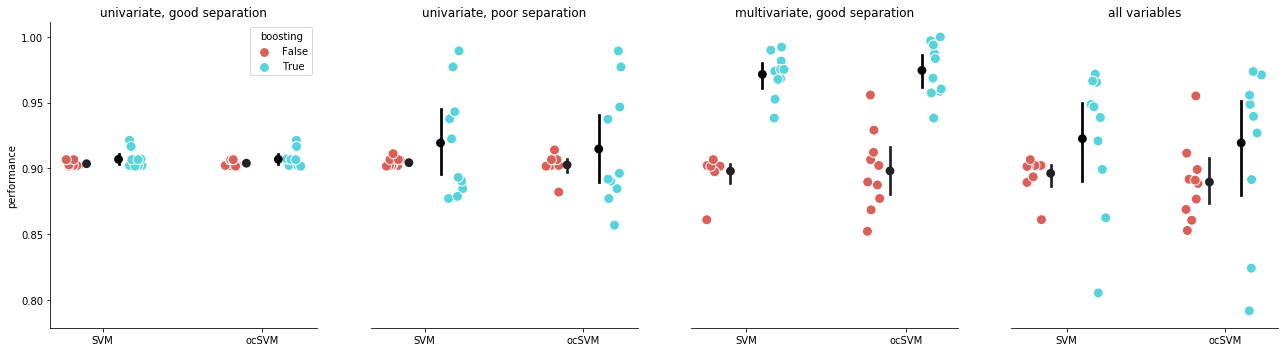

In [7]:
compare_results(data, x='classifier type', y='performance', hue='boosting', col='group',
                group_labels=group_labels, dodge=True)

When using only the variable **DS** (univariate classification, with good separation), both classifiers performed similarly, and boosting did not affect performance.

In the second univariate case, we used a variable with poorer (linear) separation between classes. As expected, the SVM classifiers achieved lower training error with a non-linear kernel, compared to an ocSVM. However, the ocSVM classifier had a greater performance compared to the SVM. Boosting improved performance to a similar value in both classifiers. It is notable that the variability between folds is much larger than the default case of un-weighted SVM.

In the first multivariate group (second panel from right), ocSVM performed as well as SVM without weighting. Here, boosting improved performance dramatically in both classifiers, reaching a similar value for unsupervised and supervised learning algorithms.

In the last group, where all variables where used, boosting improved performance of the SVM, although increasing the across-fold variability. The ocSVM classifier performed as well as SVM, as already observed in the previous multivariate case. However, boosting improved its performance, at the level of the weighted SVM classifier.

### Observations summary
KDE boosting is a suitable technique for weighting outliers in classification tasks, both supervised and unsupervised.